## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from scipy import signal
plt.style.use('seaborn-colorblind')
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

## Création des données pour la classification

Ci dessous les leviers sur lesquels jouer pour réaliser une classification. On entre le nom du jeu de données de train, de test. on choisit la taille n du filtre pour smooth les enregistrements, la longueur de la fenêtre sur laquelle on construit nos features pour les données de train et de test. liste_labels contient dans l'ordre les labels des classes par lesquelles on passe dans l'enregistrement de test, par exemple [0, 1, 0] si je suis assis puis je marche puis je suis assis. Dans liste_transition, on note les numeros des points de l'enregistrement où l'on switch d'une activité à l'autre, par exemple, si j'ai enregistré 22000 points et que j'ai changé d'activité au 8000ème point puis au 14000ème point, je prend [8000, 14000].


Il reste ensuite à choisir des features qui expliquent bien les données, pour l'instant on utilise seulement la variance sur une fenêtre et l'écart max à la valeur médiane sur la fenêtre pour l'accélération sur l'axe vertical et pour l'accélération dans le plan horizontal (norme des deux coordonnées dans ce plan). Cela fait quatre variables explicatives. 

In [2]:
def create_train(train_name, window_length, recouvrement, n, liste_labels, liste_transitions):
    def cree_labels(features, liste_transitions, liste_labels):
        #il faut bien avoir assez de label sinon on renvoie une erreur
        #liste_transitions.append(len(features))
        labels = np.zeros(len(features))
        past_index = 0
        current_index = 0
        for k in range(len(liste_transitions)):
            current_index = liste_transitions[k]
            labels[past_index : current_index] = liste_labels[k]
            past_index = current_index
        labels[liste_transitions[-1] : len(features)] = liste_labels[len(liste_transitions)]
        return labels
    data = pd.read_csv(train_name, engine = 'python')
    data = data.dropna()
    filtre = np.ones(n)
    # Il faudra trouver un filtre correct
    filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
    filteredX = signal.convolve(data.get(['x']), filtre)
    filteredY = signal.convolve(data.get(['y']), filtre)
    filteredZ = signal.convolve(data.get(['z']), filtre)
    fdata = pd.DataFrame()
    fdata['X'] = filteredX[n : - n, 0]
    fdata['Y'] = filteredY[n : - n, 0]
    fdata['Z'] = filteredZ[n : - n, 0]
    #fdata.plot()
    arrX = np.array(data.get(['x']))
    arrY = np.array(data.get(['y']))
    arrZ = np.array(data.get(['z']))
    liste_windows = []
    liste_theta_z = []
    liste_theta_y = []
    
    labels = cree_labels(fdata, liste_transitions, liste_labels).astype(int)
    labels_idee = []
    bound = 0
    while int(bound + (1 - recouvrement) * window_length) < arrX.shape[0]:
        bound = int(bound + (1 - recouvrement) * window_length)
        labels_idee.append(np.argmax(np.bincount(np.array(labels[bound : bound + window_length]))))

        # Recherche de l'accélération de la gravité sur la première seconde
        xg = arrX[bound : bound + window_length].mean()
        yg = arrY[bound : bound + window_length].mean()
        zg = arrZ[bound : bound + window_length].mean()
        G = [xg, yg, zg]
        G_objectif = [0, 0, - 9.8]
        # Il faut faire deux rotations
        # rotation autour de l'axe des ordonnées
        #On cherche l'argument dans xoy du projeté de G
        theta_z = cmath.phase(complex(G[0], G[1]))
        
        liste_theta_z.append(theta_z)

        rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
        G_rot = np.dot(G, rot_mat_z)
        # rotation autour de l'axe des abscisses

        theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))
        
        liste_theta_y.append(theta_y)

        rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
        G_rot = np.dot(G_rot, rot_mat_y)

        # Rotation complète
        rot_mat = np.dot(rot_mat_z, rot_mat_y)
        total = np.array([filteredX[bound : bound + window_length], filteredY[bound : bound + window_length], filteredZ[bound : bound + window_length]])
        total = total[:, :, 0]
        total_rot = np.dot(np.transpose(total), rot_mat)
        total_rot = np.transpose(total_rot)
        total_rot = np.array([total_rot[0, :]**2 + total_rot[1, :]**2, total_rot[2, :]])
        liste_windows.append(total_rot)
        
    train_features = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    for k in range(len(liste_windows)):
        train_features[0].append(np.var(liste_windows[k][0, :]))
        train_features[1].append(np.var(liste_windows[k][1, :]))
        train_features[2].append(np.max(np.abs(liste_windows[k][0, :]) - np.median(liste_windows[k][0, :])))
        train_features[3].append(np.max(np.abs(liste_windows[k][1, :]) - np.median(liste_windows[k][1, :])))
        train_features[4].append(np.mean((liste_windows[k][0, :])))
        train_features[5].append(np.mean((liste_windows[k][1, :])))
        train_features[6].append(np.sqrt(np.mean(np.square(liste_windows[k][0, :]))))
        train_features[7].append(np.sqrt(np.mean(np.square(liste_windows[k][1, :]))))
        train_features[8].append(np.sum((liste_windows[k][0, :-1] * liste_windows[k][0, 1:]) < 0))
        train_features[9].append(np.sum((liste_windows[k][1, :-1] * liste_windows[k][1, 1:]) < 0))
        train_features[10].append(np.trapz(liste_windows[k][0, :]))
        train_features[11].append(np.trapz(liste_windows[k][1, :]))
    train_features[12] = liste_theta_z
    train_features[13] = liste_theta_y

    train_features = np.transpose(np.array(train_features))
    train_features = train_features[ : -1, :]
    labels_idee = labels_idee[ : -1]
    return train_features, labels_idee

In [3]:
def create_test(test_name, window_length, recouvrement, n):
    data = pd.read_csv(test_name, engine = 'python')
    data = data.dropna()
    filtre = np.ones(n)
    # Il faudra trouver un filtre correct
    filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
    filteredX = signal.convolve(data.get(['x']), filtre)
    filteredY = signal.convolve(data.get(['y']), filtre)
    filteredZ = signal.convolve(data.get(['z']), filtre)
    fdata = pd.DataFrame()
    fdata['X'] = filteredX[n : - n, 0]
    fdata['Y'] = filteredY[n : - n, 0]
    fdata['Z'] = filteredZ[n : - n, 0]
    #fdata.plot()
    arrX = np.array(data.get(['x']))
    arrY = np.array(data.get(['y']))
    arrZ = np.array(data.get(['z']))
    liste_windows = []
    liste_theta_z = []
    liste_theta_y = []
    bound = 0
    while int(bound + (1 - recouvrement) * window_length) < arrX.shape[0]:
        bound = int(bound + (1 - recouvrement) * window_length)
        # Recherche de l'accélération de la gravité sur la première seconde
        xg = arrX[bound : bound + window_length].mean()
        yg = arrY[bound : bound + window_length].mean()
        zg = arrZ[bound : bound + window_length].mean()
        G = [xg, yg, zg]
        G_objectif = [0, 0, - 9.8]
        # Il faut faire deux rotations
        # rotation autour de l'axe des ordonnées
        #On cherche l'argument dans xoy du projeté de G
        theta_z = cmath.phase(complex(G[0], G[1]))

        liste_theta_z.append(theta_z)

        rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
        G_rot = np.dot(G, rot_mat_z)
        # rotation autour de l'axe des abscisses

        theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))

        liste_theta_y.append(theta_y)

        rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
        G_rot = np.dot(G_rot, rot_mat_y)

        # Rotation complète
        rot_mat = np.dot(rot_mat_z, rot_mat_y)
        total = np.array([filteredX[bound : bound + window_length], filteredY[bound : bound + window_length], filteredZ[bound : bound + window_length]])
        total = total[:, :, 0]
        total_rot = np.dot(np.transpose(total), rot_mat)
        total_rot = np.transpose(total_rot)
        total_rot = np.array([total_rot[0, :]**2 + total_rot[1, :]**2, total_rot[2, :]])
        liste_windows.append(total_rot)
        
    test_features = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
    for k in range(len(liste_windows)):
        test_features[0].append(np.var(liste_windows[k][0, :]))
        test_features[1].append(np.var(liste_windows[k][1, :]))
        test_features[2].append(np.max(np.abs(liste_windows[k][0, :]) - np.median(liste_windows[k][0, :])))
        test_features[3].append(np.max(np.abs(liste_windows[k][1, :]) - np.median(liste_windows[k][1, :])))
        test_features[4].append(np.mean((liste_windows[k][0, :])))
        test_features[5].append(np.mean((liste_windows[k][1, :])))
        test_features[6].append(np.sqrt(np.mean(np.square(liste_windows[k][0, :]))))
        test_features[7].append(np.sqrt(np.mean(np.square(liste_windows[k][1, :]))))
        test_features[8].append(np.sum((liste_windows[k][0, :-1] * liste_windows[k][0, 1:]) < 0))
        test_features[9].append(np.sum((liste_windows[k][1, :-1] * liste_windows[k][1, 1:]) < 0))
        test_features[10].append(np.trapz(liste_windows[k][0, :]))
        test_features[11].append(np.trapz(liste_windows[k][1, :]))
    test_features[12] = liste_theta_z
    test_features[13] = liste_theta_y
    
    test_features = np.transpose(np.array(test_features))
    test_features = test_features[1 : -1, :]
    return test_features

## Classification

In [4]:
def build_model(train_features, labels_idee):
    train, classes = pd.DataFrame(train_features), labels_idee
    scaler = preprocessing.RobustScaler().fit(train) # ou StandardScaler
    train_scaled = scaler.transform(train)
    pca = PCA(svd_solver = 'randomized', n_components = 13)
    train_scaled_pca = pca.fit_transform(train_scaled)
    #clf = BaggingClassifier(MLPClassifier(solver = 'adam', alpha = 1, max_iter = 200, shuffle = True, hidden_layer_sizes = (100, 100, 100)), n_estimators = 20, max_samples = 0.5)
    clf1 = KNeighborsClassifier(n_neighbors = 8)
    clf1.fit(train_scaled_pca, classes)
    #dict_weight = {0: 0.1, 1: 0.1, 2: 0.1,3: 0.1, 4: 0.6}
    #clf2 = RandomForestClassifier(n_estimators = 100, max_depth = 15) #class_weight = dict_weight)
    #clf2.fit(train_scaled_pca, classes)
    clf3 = BaggingClassifier(MLPClassifier(solver = 'adam', alpha = 1, max_iter = 200, shuffle = True, hidden_layer_sizes = (100, 100, 100)), n_estimators = 10, max_samples = 0.5)
    clf3.fit(train_scaled_pca, classes)
    return clf1, clf3, pca, scaler
    #return rf, pca, scaler

def actually_predict(classifier1, classifier2, test_features, pca, scaler):
#def actually_predict(classifier1, test_features, pca, scaler):
    test = pd.DataFrame(test_features)
    test_scaled = scaler.transform(test)
    test_scaled_pca = pca.transform(test_scaled)
    prediction1 = classifier1.predict(test_scaled_pca)
    prediction2 = classifier2.predict(test_scaled_pca)
    #prediction3 = classifier3.predict(test_scaled_pca)
    prediction = np.array((prediction1 + prediction2)/2.)
    return prediction

## Code à exécuter 

In [5]:
# Hyperparamètres
window_length = 600
recouvrement = 0.95
n = 8
train_name = 'total1.csv' 
liste_labels = [0, 1, 2, 4, 3] # 0 c'est assis, 1 c'est debout, 2 marche, 3 monte escalier, 4 descend escalier
liste_transitions = [6387, 12431, 26944, 38936] #46733

Prediction sur le train, juste pour voir : 


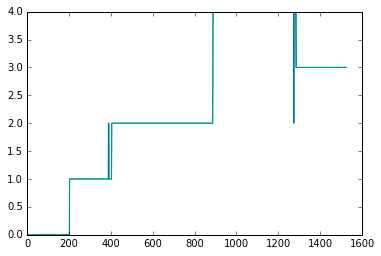

In [6]:
train_features, labels_idee = create_train(train_name, window_length, recouvrement, n, liste_labels, liste_transitions)
classifier1, classifier2, pca, scaler = build_model(train_features, labels_idee)
#classifier, pca, scaler = build_model(train_features, labels_idee)
prediction_train = actually_predict(classifier1, classifier2, train_features, pca, scaler)
#prediction_train = actually_predict(classifier, train_features, pca, scaler)
print('Prediction sur le train, juste pour voir : ')
plt.figure()
plt.plot(np.rint(prediction_train))
plt.plot(labels_idee)
plt.show()

Prediction sur le test : 


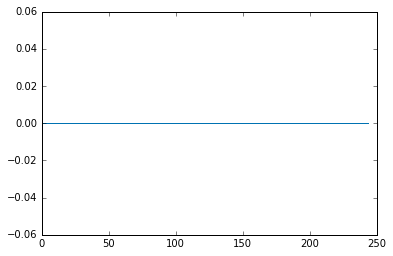

Prediction lissée sur le test


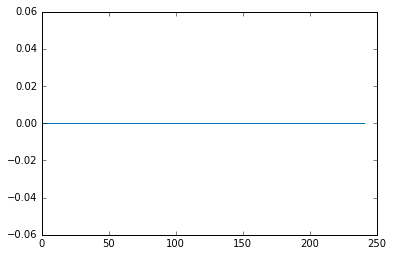

Prediction sur le test : 


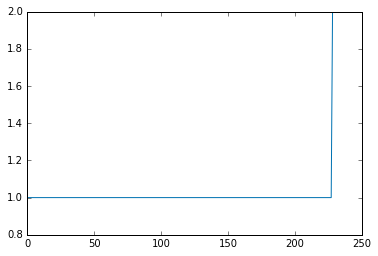

Prediction lissée sur le test


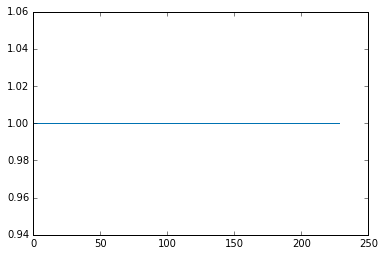

Prediction sur le test : 


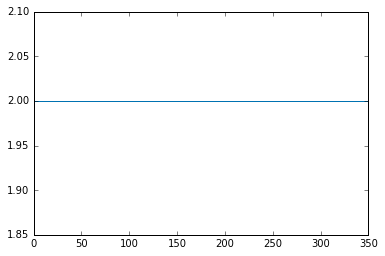

Prediction lissée sur le test


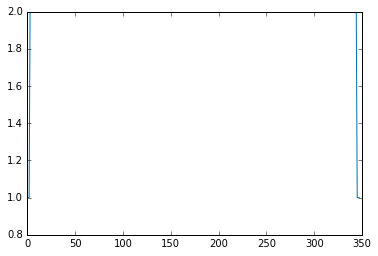

Prediction sur le test : 


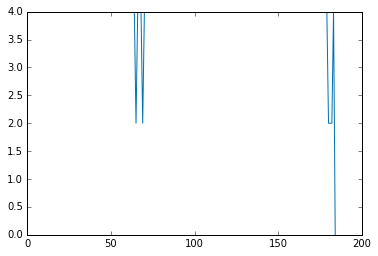

Prediction lissée sur le test


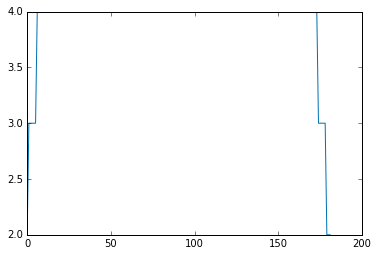

Prediction sur le test : 


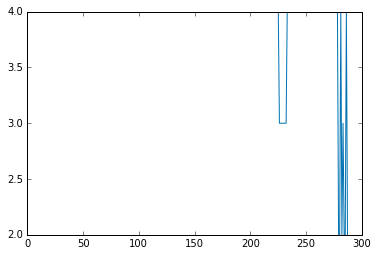

Prediction lissée sur le test


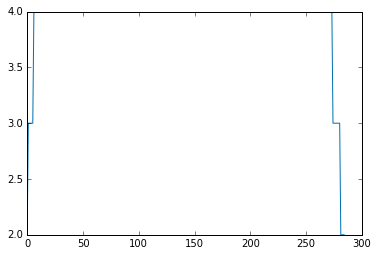

In [7]:
test_liste = ['assis2.csv', 'debout2.csv', 'marche2.csv', 'monte2.csv', 'descente2.csv']
for test_name in test_liste:
    test_features = create_test(test_name, window_length, recouvrement, n)

    print('Prediction sur le test : ')
    prediction_test = actually_predict(classifier1, classifier2, test_features, pca, scaler)
    #prediction_test = actually_predict(classifier, test_features, pca, scaler)
    plt.figure()
    plt.plot(np.rint(prediction_test))
    plt.show()

    m = 20. # "lissage" de la solution
    prediction = np.array(signal.convolve(prediction_test, np.ones(int(m))/m))
    prediction = np.rint(prediction[int(math.ceil((m - 1)/ 2) + 1) : int(- math.floor((m)/2) - 1)])

    print('Prediction lissée sur le test')
    plt.figure()
    plt.plot(prediction)
    plt.show()

## Mise en forme des résultats

In [8]:
print('Prédiction :')
etat_courant = prediction[0]
temps = 0.01 * window_length * (1 - recouvrement)
for etat in prediction:
    if etat == etat_courant:
        temps = temps + 0.010 * window_length * (1 - recouvrement)
    else:
        print('On est reste dans l`etat ', etat_courant, ' pendant ', temps, ' secondes')
        temps = 0.01 * window_length
        etat_courant = etat
print('On est reste dans l`etat ', etat_courant, ' pendant ', temps, ' secondes')
# print(prediction)

Prédiction :
('On est reste dans l`etat ', 2.0, ' pendant ', 0.6000000000000005, ' secondes')
('On est reste dans l`etat ', 3.0, ' pendant ', 7.200000000000003, ' secondes')
('On est reste dans l`etat ', 4.0, ' pendant ', 86.09999999999955, ' secondes')
('On est reste dans l`etat ', 3.0, ' pendant ', 7.800000000000004, ' secondes')
('On est reste dans l`etat ', 2.0, ' pendant ', 6.900000000000002, ' secondes')


## Algorithme de Viterbi

On part d'un modèle ($ \lambda $, A, B), il existe un moyen de faire de l'apprentissage avec des hmm mais là on devine les paramètres.

$ \lambda $ le prior, A les proba de passer d'un état à un autre, B les proba d'observer chaque observation (possible) en étant dans chaque état (array, une case par état). -> on peut avoir la densité de cette probabilité.

Autres arguments : Y les observations fixées effectivement observées, nb d'observations, d'états.

On crée deux tableaux :  celui des probabilités du chemin le plus probable jusqu'ici, en étant ici à tel état et celui des ' le dernier état du chemin le plus probable jusqu'ici ' ie le $ x_{j-1} $ le plus probable pour conduire au $ x_j = s_i $.

Ces tableaux sont construits récursivement : 

max d'un produit de matrice, on tire la probabilité selon la loi choisie pour faire office du B de wikipedia.

et l'etat qui atteint ce max.

Pour trouver ce qui va dans la matrice B, on trouve une gaussian mixture pour chaque état à l'aide de points de train. 
Quand on a une nouvelle observation on trouve la probabilité d'avoir telle observation pour tel état grace à la fonction score_samples de la gmm

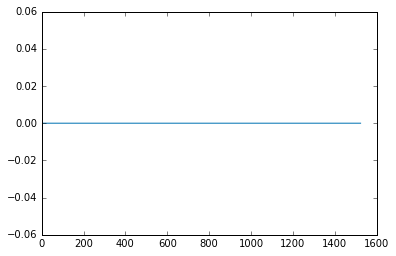

In [9]:
# On doit commencer par construire B
eps = - 10
nb_features = train_features.shape[1]
liste_states = [0,1,2,3,4]
n_gaussians = 15
set_features_etats = []
train_liste = ['assis2.csv', 'debout2.csv', 'marche2.csv', 'monte2.csv', 'descente2.csv']
for name in train_liste:
    features = create_test(name, window_length, recouvrement, n) # test car on veut juste les features, pas de labels
    #features = features[:, 0:1]
    set_features_etats.append(features)
    
liste_gmm = []
for k in liste_states:
    gmm_tmp = GaussianMixture(n_components=n_gaussians, covariance_type='full')
    gmm_tmp.fit(set_features_etats[k])
    liste_gmm.append(gmm_tmp)

K = len(liste_states)
prior = np.random.rand(K)
prior = prior/np.sum(prior) # stochastique
test_observation = 'total1.csv'
features_observation = create_test(test_observation, window_length, recouvrement, n) 
#features_observation = features_observation[:, 0:1]
T = features_observation.shape[0]
T1 = np.zeros((K, T))
T2 = np.zeros((K, T))
A = np.array([[0.9, 0.1, 0, 0, 0],
             [0.03, 0.9, 0.05, 0.01, 0.01],
             [0.005, 0.055, 0.9, 0.02, 0.02],
             [0, 0.03, 0.07, 0.9, 0],
             [0, 0.03, 0.07, 0, 0.9]])
z = np.zeros(T)
for i in liste_states:
    tmp = liste_gmm[i].score_samples(features_observation[0]) 
    if tmp < eps:
        tmp = [eps]
    T1[i, 0] = prior[i] * np.exp(tmp)
    #print(tmp)
for i in range(1, T): 
    for j in range(K):
        tmp = liste_gmm[j].score_samples(features_observation[i]) 
        if tmp < eps:
            tmp = [eps]
        #print(tmp)
        T1[j, i] = np.exp(tmp) * np.max(T1[:, i - 1] * A[:, j])
        T2[j, i] = np.argmax(T1[:, i - 1] * A[:, j])
z[T - 1] = np.argmax(T1[:, T - 1])
for i in range(T - 2, -1, -1):
    z[i] = T2[int(z[i + 1]), i + 1]

#for i in range(1, T): 
#    print(T1[:, i])

plt.figure()
plt.plot(z)
plt.show()

In [11]:
def gaussian_pdf(mu, sigma, x):
    return(1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2)))

[  7.65277801e-001   7.00783782e-017   4.15956902e-098   9.48832140e-201
   0.00000000e+000]
[  6.34518199e-001   4.98748538e-031   6.00963975e-120   1.17669014e-236
   0.00000000e+000]
[  1.60310396e+000   7.85022162e-027   5.05829347e-126   6.17021613e-239
   0.00000000e+000]
[  4.99627190e+000   2.18937437e-020   7.86463459e-110   8.58476950e-217
   0.00000000e+000]
[  1.68965637e+001   1.13775822e-023   5.62004594e-111   9.42687144e-222
   0.00000000e+000]
[  6.02353600e+001   3.90863787e-022   2.85900739e-112   4.62131240e-222
   0.00000000e+000]
[  2.04063581e+002   1.32252929e-019   9.31072162e-107   1.50313941e-214
   0.00000000e+000]
[  6.61939159e+002   1.56563606e-022   4.01760908e-111   2.36709966e-222
   0.00000000e+000]
[  2.26427786e+003   2.15813465e-021   8.14449986e-113   1.93370118e-223
   0.00000000e+000]
[  3.68736739e-011   1.56435411e+002   1.05892905e-052   1.11908132e-126
   2.19977489e-243]
[  9.60657317e-024   4.75731650e+002   1.62298179e-018   7.41514347e-0

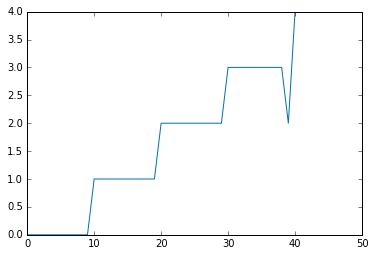

In [34]:
# Avec un dataset jouet
from numpy.random import normal

N1 = normal(0.0, 0.1, 10)
N2 = normal(1.0, 0.1, 10)
N3 = normal(2.0, 0.1, 10)
N4 = normal(3.0, 0.1, 10)
N5 = normal(4.0, 0.1, 10)


liste_states = [0, 1, 2, 3, 4]
eps = -100000000
K = len(liste_states)
prior = np.random.rand(K)
prior = prior/np.sum(prior) # stochastique
features_observation = np.concatenate((N1, N2, N3, N4, N5), axis=0)
T = features_observation.shape[0]
T1 = np.zeros((K, T))
T2 = np.zeros((K, T))
A = np.array([[0.9, 0.1, 0, 0, 0],
             [0.03, 0.9, 0.05, 0.01, 0.01],
             [0.005, 0.055, 0.9, 0.02, 0.02],
             [0, 0.03, 0.07, 0.9, 0],
             [0, 0.03, 0.07, 0, 0.9]])
z = np.zeros(T)
for i in liste_states:
    tmp = np.log(gaussian_pdf(i, 0.1, features_observation[0]))
    if tmp < eps:
        tmp = [eps]
    T1[i, 0] = prior[i] * np.exp(tmp)
for i in range(1, T): 
    for j in range(K):
        tmp = np.log(gaussian_pdf(j, 0.1, features_observation[i]))
        if tmp < eps:
            tmp = [eps]
        T1[j, i] = np.exp(tmp) * np.max(T1[:, i - 1] * A[:, j])
        T2[j, i] = np.argmax(T1[:, i - 1] * A[:, j])
z[T - 1] = np.argmax(T1[:, T - 1])
for i in range(T - 2, -1, -1):
    z[i] = T2[int(z[i + 1]), i + 1]

for i in range(1, T): 
    print(T1[:, i])

plt.figure()
plt.plot(z)
plt.show()